In [1]:
from ime_pylib import scan_tools as sc

import matplotlib.pyplot as plt
import numpy as np
import sympy
import scipy as sp
from scipy.optimize import curve_fit

In [43]:
sc.set_path("./IME_datfiles")
res_e = sc.scan_load(623)

# soreted specific files that should be loaded into different folders
# as to not overload memory with useless data
sc.set_path("./IME_datfiles/h2o/")
res_h2o = sc.scan_load(629,644)
sc.set_path("./IME_datfiles/d2o/")
res_d2o = sc.scan_load(646,647)
sc.set_path("./IME_datfiles/h2olipid/")
res__h2olip = sc.scan_load(652)
sc.set_path("./IME_datfiles/d2olipid/")
res_d2olip = sc.scan_load(655,666)

File: ./IME_datfiles/MKA_000623.mat loaded . top_function: measure_c_bridge_lin (name identified from number)
File: ./IME_datfiles/h2o/MKA_000629.mat loaded . top_function: measure_c_bridge_lin (name identified from number)
No or multiple file(s) with numer: range(629, 645)
No or multiple file(s) with numer: range(629, 645)
No or multiple file(s) with numer: range(629, 645)
No or multiple file(s) with numer: range(629, 645)
No or multiple file(s) with numer: range(629, 645)
No or multiple file(s) with numer: range(629, 645)
No or multiple file(s) with numer: range(629, 645)
No or multiple file(s) with numer: range(629, 645)
No or multiple file(s) with numer: range(629, 645)
No or multiple file(s) with numer: range(629, 645)
No or multiple file(s) with numer: range(629, 645)
No or multiple file(s) with numer: range(629, 645)
No or multiple file(s) with numer: range(629, 645)
File: ./IME_datfiles/h2o/MKA_000643.mat loaded . top_function: measure_c_bridge_lin (name identified from number)

In [21]:
# generic empty resonance frequency equation
def model(f, Ccl, Cfr, f0, Q):
    x = f/f0
    return Ccl + (Cfr-Ccl)/(1 - x**2 + 1j*x/Q)

# curve fits by least-square integration to given model, starting from p0
def fit(var_model, fdata, ydata, p0):
    
    def fit_func(fdata, *args):
        m = var_model(fdata, *args)
        return np.abs(m)
    
    ydata_real = np.abs(ydata)
    popt, _ = curve_fit(fit_func, fdata, ydata_real, p0)
    return popt

# 
def makefits(var_model, data, p0, S=0):
    
    if var_model == model:
        data_fit = np.zeros((len(data),4000), dtype=complex)
        popt_data = np.zeros((len(data),4))
    
        for i in range(0, len(data)):
            # find values for parameters
            popt_data[i] = fit(model, data[i].fr_bridge, data[i].C_bridge, p0)

            # the model sometimes comes up with negative values for a parameter
            # Since we know they are all positive, this always corrects that
            popt_data[i] = np.abs(popt_data[i])

            # find the ydata for the fit to plot it later
            data_fit[i] = model(data[i].fr_bridge, *popt_data[i])

        return data_fit, popt_data
    
    if var_model == stiffmodel:
        data_fit = np.zeros((len(data),4000), dtype=complex)
        popt_data = np.zeros((len(data),2))
        for i in range(0, len(data)):
            # find values for parameters
            popt_data[i] = fit(stiffmodel, data[i].fr_bridge, S[i], p0)

            # the model sometimes comes up with negative values for a parameter
            # Since we know they are all positive, this always corrects that
            popt_data[i] = np.abs(popt_data[i])

            # find the ydata for the fit to plot it later
            data_fit[i] = stiffmodel(data[i].fr_bridge, *popt_data[i])
        
        return data_fit, popt_data
    
    raise ValueError("this function can not fit data to the model ", var_model)

In [22]:
popt_data = np.zeros((len(res_e),2))
data_fit = np.zeros((len(res_e),4000), dtype=complex)
for i in range(len(res_e)):
    popt_data[i] = fit(stiffmodel, res_e[i].fr_bridge, S_e[i], p0)
    popt_data[i] = np.abs(popt_data[i])
    
    data_fit[i] = stiffmodel(res_e[i].fr_bridge, *popt_data[i])
popt_data

array([[14336036.75051092,    30002.55160806]])

In [5]:
Ccl_0 = 1.7e-8
Cfr_0 = 2e-8
f0_0 = 9.3e4
Q_0 = 100

p0 = Ccl_0, Cfr_0, f0_0, Q_0
Cfit_d2o, popt_d2o = makefits(model, res_d2o, p0)
Cfit_e, popt_e = makefits(model, res_e, p0)
Cfit_h2o, popt_h2o = makefits(model, res_h2o, p0)
popt_d2o

array([[1.75914910e-08, 1.94994636e-08, 8.45035715e+04, 1.53222233e+02],
       [1.75894407e-08, 1.94962237e-08, 8.44975618e+04, 1.64114459e+02]])

In [6]:
ccycle = ['b', 'r', 'g', 'm', 'k', 'c']
def plotfigs(data, fit, *line, size=(8,6), realimag='both', compare=False, alpha=1, xlim=(0,4e5), logscale=False, ylim=(0,0)):
    
    plt.figure(figsize = size)
    if realimag == 'both' or realimag == 'real':
        for i in range(len(data)):
            if compare == True:
                alpha = 0.6
                plt.plot(data[i].fr_bridge, data[i].C_bridge.real, ls='dotted', c= ccycle[i])
            plt.plot(data[i].fr_bridge, fit[i].real, ls='-',c = ccycle[i], alpha=alpha)
        
        for arg in line:
            if  arg[0] == 'x':
                plt.axvline(arg[1], linestyle=':', color='k')
            else:
                plt.axhline(arg[1], linestyle=':', color='k')
        plt.xlim(xlim)
        if logscale == True:
            plt.xscale('log')
        if ylim != (0,0):
            plt.ylim(ylim)
        plt.show()
        
    plt.figure(figsize = size)
    if realimag == 'both' or realimag == 'imag':
        for i in range(len(data)):
            if compare == True:
                alpha = 0.6
                plt.plot(data[i].fr_bridge, data[i].C_bridge.real, ls ='dotted', c=ccycle[i])
            plt.plot(data[i].fr_bridge, fit[i].real, ls='-', c= ccycle[i], alpha=alpha)
        for arg in line:
            if arg[0] == 'x':
                plt.axvline(arg[1], linestyle=':', color='k')
            else:
                plt.axhline(arg[1], linestyle=':', color='k')
        plt.xlim(xlim)
        if logscale == True:
            plt.xscale('log')
        if ylim != (0,0):
            plt.ylim(ylim)
        plt.show()

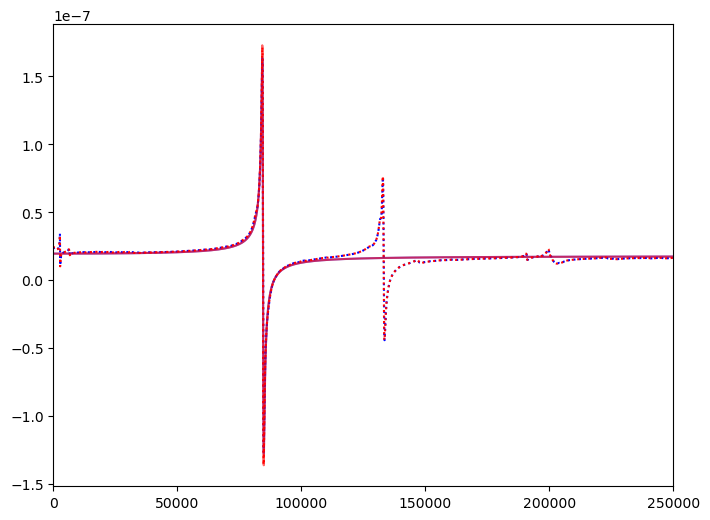

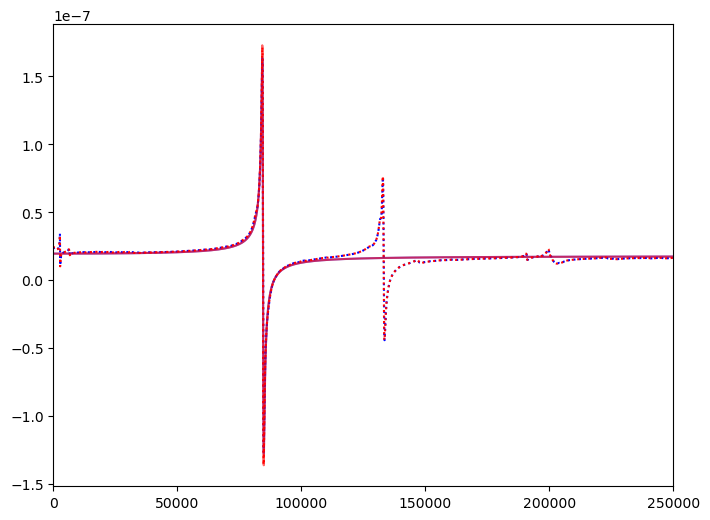

In [7]:
#plt.rc('font', size=12)
plotfigs(res_d2o, Cfit_d2o, compare=True, xlim = (0,2.5e5))

## normalize capacitance

$$F(f) = \frac{C_m(f) - C_{cl}}{C_{fr} - C_{cl}}$$

In [8]:
def normcap(Cm,Ccl,Cfr):
    return (Cm - Ccl)/(Cfr - Ccl)

def normloop(data, popt):
    F = np.zeros_like(data)
    for i in range(0, len(data)):
        F[i] = normcap(data[i].C_bridge, popt[i][0], popt[i][1])
    return F

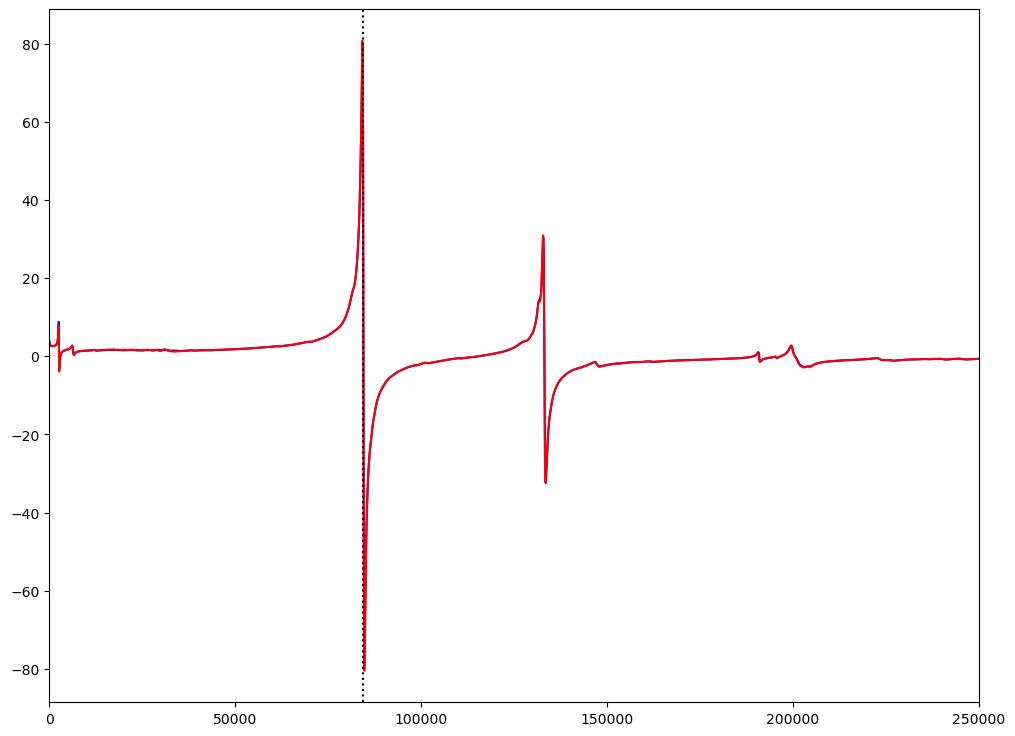

<Figure size 1200x900 with 0 Axes>

In [9]:
F_e = normloop(res_e, popt_e)
F_h2o = normloop(res_h2o, popt_h2o)
F_d2o = normloop(res_d2o, popt_d2o)

plotfigs(res_d2o, F_d2o, ('x',popt_d2o[0][2]), size = (12,9), realimag='real', xlim=(0,2.5e5))

## stiffness+bulk modulus

$$S_{\mathrm{liq}} = L \omega_0^2 \left( \frac{1}{F(\omega)} - 1 + \left( \frac{\omega}{\omega_0} \right)^2 - i \frac{\omega}{\omega_0} \frac{1}{Q} \right)$$

In [10]:
m = 0.005
r0 = 0.01
L = m/(4*np.pi*(r0**2))**2
V = (4/3)*np.pi*(r0**3)

def stiffness(f, f0, Q, F, L):
    return L*((2*np.pi*f0)**2)*((1/F) - 1 + (f/f0)**2 - 1j*(f/f0)*(1/Q))

def stiffloop(data, popt, F, L):
    S = np.zeros_like(data)

    for i in range(0,len(data)):
        S[i] = stiffness(data[i].fr_bridge, popt[i][2], popt[i][3], F[i], L)
    return S

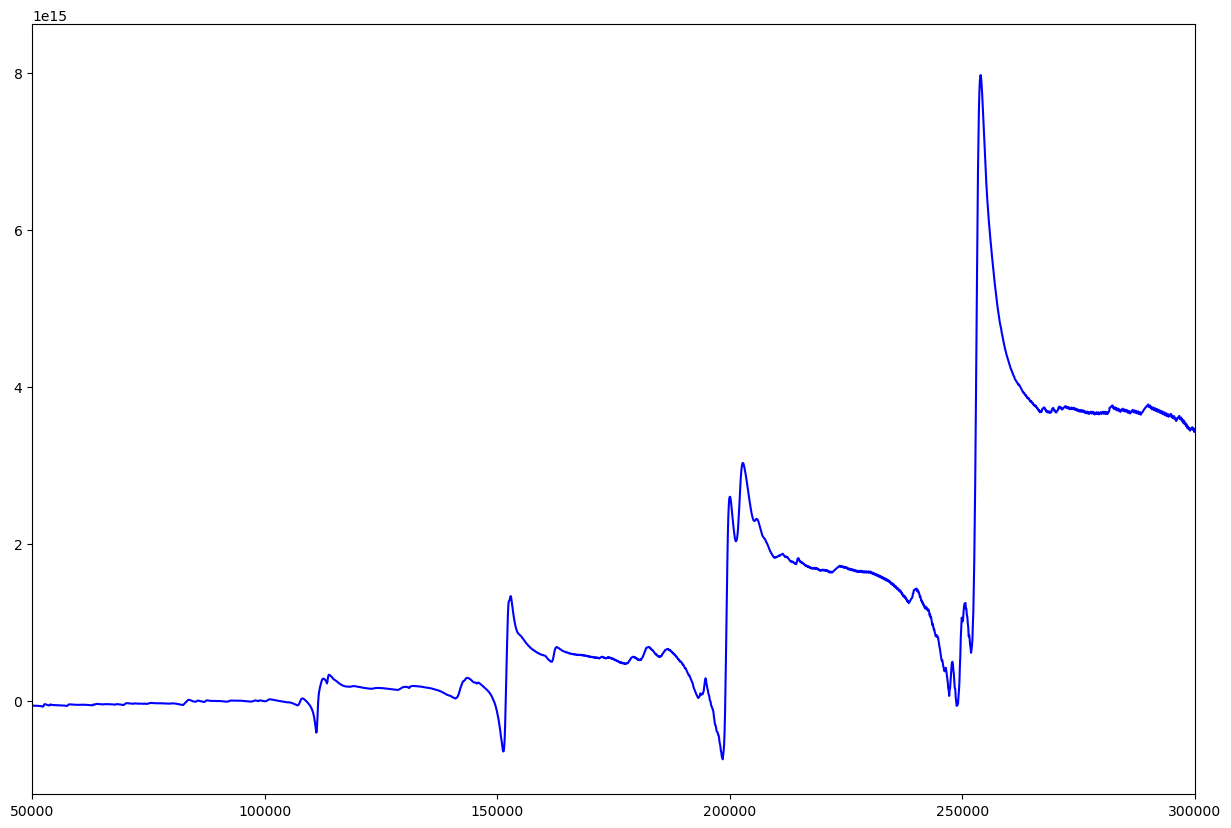

<Figure size 1500x1000 with 0 Axes>

In [11]:
S_e = stiffloop(res_e, popt_e, F_e, L)
S_h2o = stiffloop(res_h2o, popt_h2o, F_h2o, L)
S_d2o = stiffloop(res_d2o, popt_d2o, F_d2o, L)

#plt.ylim(0e9, 4e9)
plotfigs(res_e,S_e,xlim=(5e4, 3e5), size=(15,10),realimag='real')

## function for fitting stiffness stuff

$$\frac{1}{C_{liq}(\omega)} =S_{liq}(\omega) = \frac{K}{V} g\left( \frac{\omega}{\omega_r} \right) \mathrm{where}\  g(x) = -\frac{1}{3} \frac{x^2 \sin x}{x \cos x - \sin x} +2/3 \ ,\ \omega_r = \sqrt{ \frac{K}{\rho} } \frac{1}{r_0}$$

$$ \Rightarrow S(\omega) = - \frac{K}{4*\pi*r^3} \left(\frac{ x^2 \sin (x)}{x \cos (x) - \sin (x)} +2/3 \right)\ ,\ x=\frac{\omega}{\omega_r} = \frac{\omega}{\sqrt{K/\rho}} *r_0 $$


In [12]:
# define stiffness
def stiffmodel(f, K, fr):
    x = f/fr
    return (-K/(4*np.pi*(0.01)**3))*(((x**2)*np.sin(x))/(x * np.cos(x) - np.sin(x)))

In [24]:
p0 = 2.1e9, 3e4

S_fit_e, popt_S_e = makefits(stiffmodel, res_e, p0, S=S_e)
S_fit_h2o, popt_S_h2o = makefits(stiffmodel, res_h2o, p0, S=S_h2o)
S_fit_d2o, popt_S_d2o = makefits(stiffmodel, res_d2o, p0, S=S_d2o)

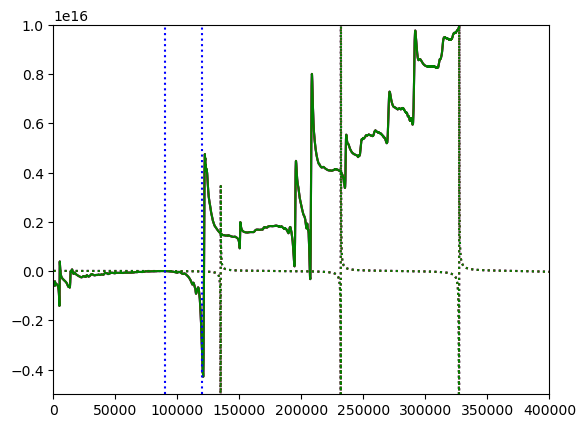

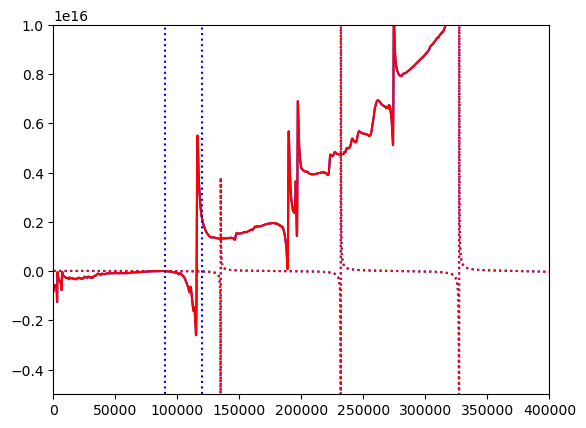

In [38]:
def drawScomparison(data, S, S_fit):
    for i in range(len(data)):
        plt.plot(data[0].fr_bridge, S_fit[0], ls='dotted', c=ccycle[i])
        plt.plot(data[0].fr_bridge, S[0], ls='-', c=ccycle[i])
    plt.axvline(data[0].fr_bridge[900], linestyle=':', color='b')
    plt.axvline(data[0].fr_bridge[1200], linestyle=':', color='b')
    #plt.xlim(8e4,)
    plt.xlim(0,4e5)
    plt.ylim(-5e15,1e16)
    #plt.ylim(-3e15, 3e15)
    #plt.xscale('log')
    plt.show()
drawScomparison(res_h2o, S_h2o, S_fit_h2o)
drawScomparison(res_d2o, S_d2o, S_fit_d2o)
#plotfigs(res_h2o, S_fit_h2o, ('x', res_h2o[0].fr_bridge[900]), ('x',res_h2o[0].fr_bridge[1200]), realimag='real',xlim=(0,4e5), ylim =(-5e15,1e16))

In [39]:
'''def filledmodel(f, Ccl, Cfr, Cliq, f0, Q):
    x = f/f0
    return Ccl + (Cfr-Ccl)/(1 - x**2 + 1j*x/Q + (Cfr-Ccl)/Cliq)

poptnew = np.zeros((4,0))
p0new = popt[10][0], popt[10[1], 1e-7, popt[10][2], popt[10][3]
poptnew = fit(filledmodel, res[10].fr_bridge, res[10].C_bridge, p0new)
Cfit = filledmodel(res[10].fr_bridge, *poptnew)'''

'def filledmodel(f, Ccl, Cfr, Cliq, f0, Q):\n    x = f/f0\n    return Ccl + (Cfr-Ccl)/(1 - x**2 + 1j*x/Q + (Cfr-Ccl)/Cliq)\n\npoptnew = np.zeros((4,0))\np0new = popt[10][0], popt[10[1], 1e-7, popt[10][2], popt[10][3]\npoptnew = fit(filledmodel, res[10].fr_bridge, res[10].C_bridge, p0new)\nCfit = filledmodel(res[10].fr_bridge, *poptnew)'

In [53]:
def filledmodel(f, Ccl, Cfr, f0, Q, K, fr, L):
    x = f/f0
    S = stiffmodel(f, K, fr)
    return Ccl + (Cfr-Ccl)/(1 - x*x + 1j*x/Q + S/(L*(2*np.pi*f0)**2))

def calcfilledmodel(data, popt_C, popt_S, L):
    C_fit = np.zeros_like(data)
    for i in range(len(data)):
        C_fit[i] = filledmodel(data[i].fr_bridge, *popt_C[i], *popt_S[i], L)
    return C_fit

C_e = calcfilledmodel(res_e, popt_e, popt_S_e, L)
C_h2o= calcfilledmodel(res_h2o, popt_h2o, popt_S_h2o, L)
C_d2o= calcfilledmodel(res_d2o, popt_d2o, popt_S_d2o, L)
#Cwater = filledmodel(res[10].fr_bridge, popt[10][0], popt[10][1], popt[10][2], popt[10][3], popt_Swater[0], popt_Swater[1], L)
np.shape(C_e[0])

(4000,)

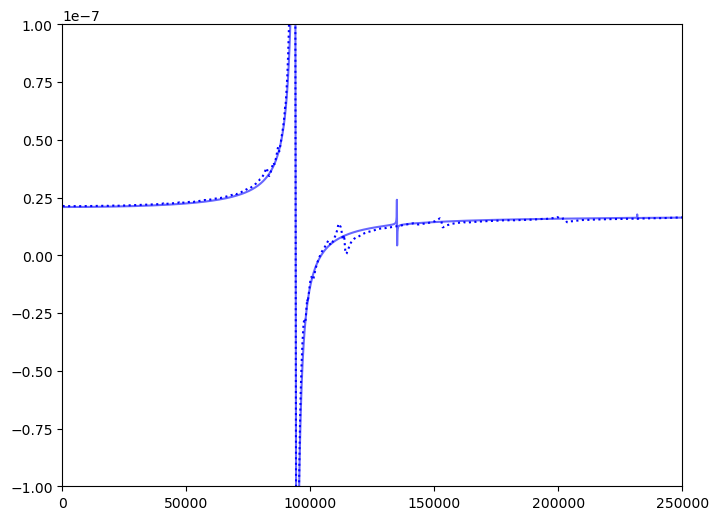

<Figure size 800x600 with 0 Axes>

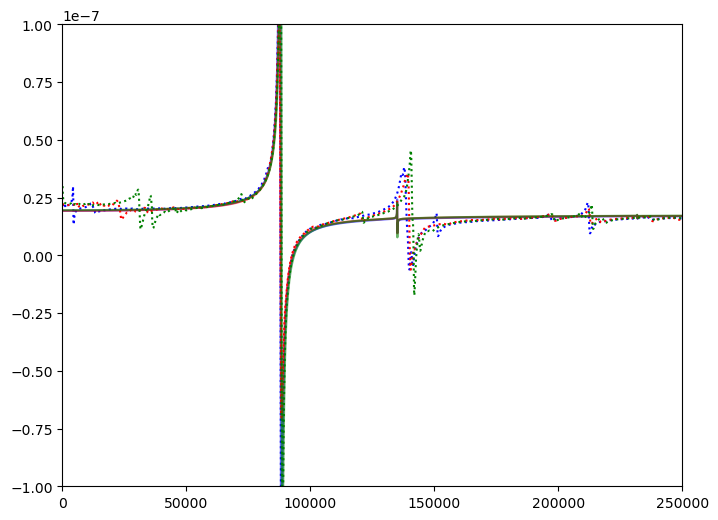

<Figure size 800x600 with 0 Axes>

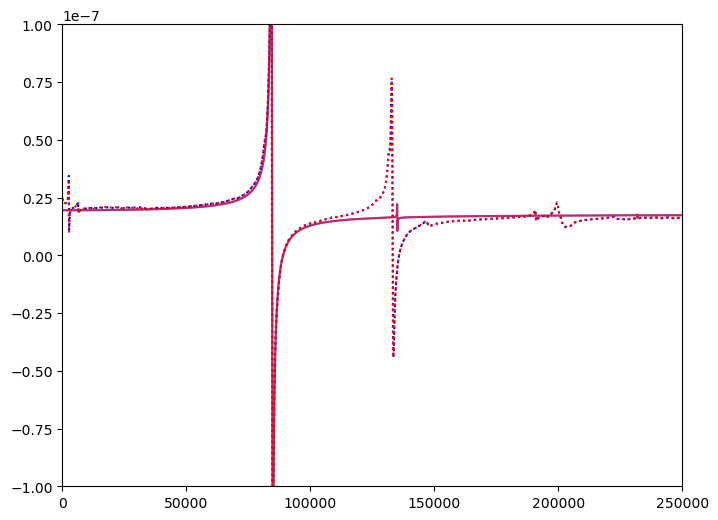

<Figure size 800x600 with 0 Axes>

In [55]:
#plt.plot(res[10].fr_bridge, np.real(res[10].C_bridge), '.r')
#plt.plot(res[10].fr_bridge, np.real(Cwater), '-b', alpha =.7) 

plotfigs(res_e, C_e, compare=True, xlim=(0,2.5e5), ylim=(-1e-7,1e-7), realimag='real')
plotfigs(res_h2o, C_h2o, compare=True, xlim=(0,2.5e5), ylim=(-1e-7,1e-7), realimag='real')
plotfigs(res_d2o, C_d2o, compare=True, xlim=(0,2.5e5), ylim=(-1e-7,1e-7), realimag='real')
#plt.xlim(0,2.5e5)
#plt.ylim(-1e-7,1e-7)